<a href="https://colab.research.google.com/github/ryrynbob/ust-deep-learning-2026/blob/main/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3

## Set up and Data

## Training Set Size

In [9]:
train_sizes = [6000 * i for i in range(1, 11)]  # 10% increments up to 60,000
train_sizes


[6000, 12000, 18000, 24000, 30000, 36000, 42000, 48000, 54000, 60000]

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [11]:



# Reproducibility
SEED = 42
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)

# Load MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize to [0,1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Add channel dimension for CNN: (N, 28, 28, 1)
x_train_cnn = x_train[..., None]
x_test_cnn  = x_test[..., None]

# Flatten for FCN: (N, 784)
x_train_fcn = x_train.reshape(-1, 28*28)
x_test_fcn  = x_test.reshape(-1, 28*28)

num_classes = 10


## Define the two models

In [12]:
def build_fcn():
    model = keras.Sequential([
        layers.Input(shape=(784,)),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


## Convolutional (CNN)

In [13]:
def build_cnn():
    model = keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


## Train both models across multiple sample sizes (show data)

In [14]:
EPOCHS = 5
BATCH = 128

results = []

for n in train_sizes:
    print(f"\n=== Training size: {n} ===")
    idx = np.random.choice(len(x_train), size=n, replace=False)

    # FCN
    fcn = build_fcn()
    fcn.fit(x_train_fcn[idx], y_train[idx],
            epochs=EPOCHS, batch_size=BATCH, verbose=0,
            validation_split=0.1)
    fcn_test_loss, fcn_test_acc = fcn.evaluate(x_test_fcn, y_test, verbose=0)

    # CNN
    cnn = build_cnn()
    cnn.fit(x_train_cnn[idx], y_train[idx],
            epochs=EPOCHS, batch_size=BATCH, verbose=0,
            validation_split=0.1)
    cnn_test_loss, cnn_test_acc = cnn.evaluate(x_test_cnn, y_test, verbose=0)

    results.append({
        "train_size": n,
        "fcn_test_acc": float(fcn_test_acc),
        "cnn_test_acc": float(cnn_test_acc),
        "fcn_test_loss": float(fcn_test_loss),
        "cnn_test_loss": float(cnn_test_loss),
    })

df = pd.DataFrame(results)
df



=== Training size: 6000 ===

=== Training size: 12000 ===

=== Training size: 18000 ===

=== Training size: 24000 ===

=== Training size: 30000 ===

=== Training size: 36000 ===

=== Training size: 42000 ===

=== Training size: 48000 ===

=== Training size: 54000 ===

=== Training size: 60000 ===


,train_size,fcn_test_acc,cnn_test_acc,fcn_test_loss,cnn_test_loss
0,6000,0.9322,0.9685,0.219725,0.102779
1,12000,0.9526,0.9829,0.155783,0.055265
2,18000,0.9585,0.9829,0.131698,0.050307
3,24000,0.9636,0.9850,0.108293,0.043970
4,30000,0.9697,0.9871,0.099766,0.038755
5,36000,0.9718,0.9897,0.095270,0.032535
6,42000,0.9725,0.9883,0.086412,0.034436
7,48000,0.9759,0.9890,0.076416,0.033282
8,54000,0.9768,0.9910,0.070996,0.029145
9,60000,0.9779,0.9895,0.073674,0.029272


## Plot accuracy vs training data size

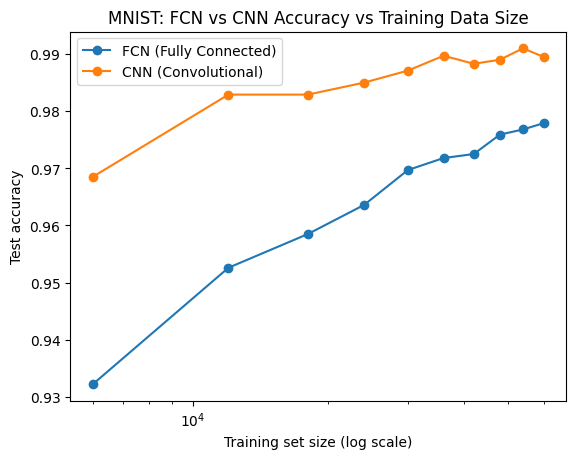

In [16]:
plt.figure()
plt.plot(df["train_size"], df["fcn_test_acc"], marker="o", label="FCN (Fully Connected)")
plt.plot(df["train_size"], df["cnn_test_acc"], marker="o", label="CNN (Convolutional)")
plt.xscale("log")
plt.xlabel("Training set size (log scale)")
plt.ylabel("Test accuracy")
plt.title("MNIST: FCN vs CNN Accuracy vs Training Data Size" )
plt.legend()
plt.show()


## Decide who plateaus first

In [17]:
def first_plateau_point(sizes, accs, eps=0.002, consecutive=2):
    sizes = list(sizes)
    accs = list(accs)
    gains = [accs[i+1] - accs[i] for i in range(len(accs)-1)]

    for i in range(len(gains) - (consecutive - 1)):
        if all(g < eps for g in gains[i:i+consecutive]):
            return sizes[i], gains
    return None, gains

fcn_plateau, fcn_gains = first_plateau_point(df["train_size"], df["fcn_test_acc"])
cnn_plateau, cnn_gains = first_plateau_point(df["train_size"], df["cnn_test_acc"])

print("FCN gains:", [round(g, 5) for g in fcn_gains])
print("CNN gains:", [round(g, 5) for g in cnn_gains])
print("FCN plateau point:", fcn_plateau)
print("CNN plateau point:", cnn_plateau)

if fcn_plateau is None and cnn_plateau is None:
    print("No plateau detected for either with current eps/epochs.")
elif fcn_plateau is None:
    print("CNN plateaus first (FCN didn't plateau by this rule).")
elif cnn_plateau is None:
    print("FCN plateaus first (CNN didn't plateau by this rule).")
else:
    print("Plateaus first:", "FCN" if fcn_plateau < cnn_plateau else "CNN")


FCN gains: [0.0204, 0.0059, 0.0051, 0.0061, 0.0021, 0.0007, 0.0034, 0.0009, 0.0011]
CNN gains: [0.0144, 0.0, 0.0021, 0.0021, 0.0026, -0.0014, 0.0007, 0.002, -0.0015]
FCN plateau point: 48000
CNN plateau point: 36000
Plateaus first: CNN


In [18]:
def first_plateau_abs(sizes, accs, eps=0.005, consecutive=2):
    sizes = list(sizes)
    accs = list(accs)
    gains = [accs[i+1] - accs[i] for i in range(len(accs)-1)]
    for i in range(len(gains) - (consecutive - 1)):
        if all(g < eps for g in gains[i:i+consecutive]):
            return sizes[i], gains
    return None, gains

fcn_plateau, fcn_gains = first_plateau_abs(df["train_size"], df["fcn_test_acc"], eps=0.005)
cnn_plateau, cnn_gains = first_plateau_abs(df["train_size"], df["cnn_test_acc"], eps=0.005)

print("FCN gains:", [round(g, 5) for g in fcn_gains])
print("CNN gains:", [round(g, 5) for g in cnn_gains])
print("FCN plateau at:", fcn_plateau)
print("CNN plateau at:", cnn_plateau)


FCN gains: [0.0204, 0.0059, 0.0051, 0.0061, 0.0021, 0.0007, 0.0034, 0.0009, 0.0011]
CNN gains: [0.0144, 0.0, 0.0021, 0.0021, 0.0026, -0.0014, 0.0007, 0.002, -0.0015]
FCN plateau at: 30000
CNN plateau at: 12000


In [19]:
def first_plateau_rel(sizes, accs, rel_eps=0.003, consecutive=2):
    sizes = list(sizes)
    accs = list(accs)
    rel_gains = [ (accs[i+1]-accs[i]) / max(accs[i], 1e-8) for i in range(len(accs)-1) ]
    for i in range(len(rel_gains) - (consecutive - 1)):
        if all(r < rel_eps for r in rel_gains[i:i+consecutive]):
            return sizes[i], rel_gains
    return None, rel_gains

fcn_plateau_r, fcn_rel = first_plateau_rel(df["train_size"], df["fcn_test_acc"], rel_eps=0.003)
cnn_plateau_r, cnn_rel = first_plateau_rel(df["train_size"], df["cnn_test_acc"], rel_eps=0.003)

print("FCN relative gains:", [round(r, 5) for r in fcn_rel])
print("CNN relative gains:", [round(r, 5) for r in cnn_rel])
print("FCN rel-plateau at:", fcn_plateau_r)
print("CNN rel-plateau at:", cnn_plateau_r)


FCN relative gains: [0.02188, 0.00619, 0.00532, 0.00633, 0.00217, 0.00072, 0.0035, 0.00092, 0.00113]
CNN relative gains: [0.01487, 0.0, 0.00214, 0.00213, 0.00263, -0.00141, 0.00071, 0.00202, -0.00151]
FCN rel-plateau at: 30000
CNN rel-plateau at: 12000


Using 10% training-size increments from 6,000 to 60,000 MNIST images, the CNN both learns faster and reaches a higher accuracy ceiling than the fully connected network (FCN): at 6k samples the CNN is already 0.9685 vs FCN 0.9322, and across all sizes the CNN stays ahead, peaking around 0.9910 (54k) while the FCN tops out around 0.9779 (60K). When we quantify "plateau" as the point after which additional data yields consistently tiny gains, the CNN plateaus first: its marginal gains become near-zero by the mid-high data regime (e.g., after 36k the gains fluctuate around ~0% and even dip slightly), wheras the FCN continues to creep upward longer before flattening (small but positive gains persisting into the 48k - 60k range). This matches the inductive bias story: convolution leverages spatial structure and weight sharing, so it extracts strong digit features with less data and saturates earlier at a higher level, while the FCN needs more data to approximate the same invariances and strill plateaus lower.